In [1]:
import tenseal as ts
import os
import utils
import flwr as fl
import tensorflow as tf
from tensorflow import keras
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from fractions import Fraction
from sklearn.metrics import confusion_matrix

In [2]:
# Load and compile Keras model
# model = keras.Sequential([
    #keras.layers.Flatten(input_shape=(28,28)),
    #keras.layers.Dense(128, activation='relu'),
    #keras.layers.Dense(256, activation='relu'),
    #keras.layers.Dense(10, activation='softmax')])
#model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])'''

In [2]:
# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
dist = [4000, 4000, 4000, 3000, 10, 10, 10, 10, 4000, 10]

In [4]:
# Slicing the MNIST original dataset to retain only part of the dataset.
#x_train = x_train[20000:,:,:]
#y_train = y_train[20000:]
#x_test = x_test[4000:,:,:]
#y_test  = y_test[4000:]

In [3]:
# Auxillary methods
def getDist(y):
    ax = sns.countplot(x = y)
    ax.set(title="Count of data classes")
    plt.show()

def getData(dist, x, y):
    dx = []
    dy = []
    counts = [0 for i in range(10)]
    for i in range(len(x)):
        if counts[y[i]]<dist[y[i]]:
            dx.append(x[i])
            dy.append(y[i])
            counts[y[i]] += 1
        
    return np.array(dx), np.array(dy)

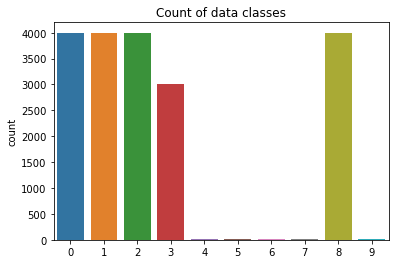

In [4]:
x_train, y_train = getData(dist, x_train, y_train)
getDist(y_train)

In [7]:
# Slicing the MNIST original dataset to retain only part of the dataset.
#x_train = x_train[20000:40596,:,:]
#y_train = y_train[20000:40596]
#x_test = x_test[4000:7139,:,:]
#y_test  = y_test[4000:7139]

In [8]:
# Length of the new dataset
print("x_train:", len(x_train))
print("y_train:", len(y_train))
print("x_test:", len(x_test))
print("y_test:", len(y_test))

x_train: 19050
y_train: 19050
x_test: 10000
y_test: 10000


In [9]:
# Retrieve the base model
new_model = tf.keras.models.load_model('./saved_model/base_model')
# Check its architecture.
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7840      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                100       
                                                                 
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Creating a multiclass confusion matrix before training.
predictions = new_model.predict(x_test)
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion

313/313 [==============================] - 2s 3ms/step


array([[ 950,    0,    3,    2,    2,    6,   11,    1,    5,    0],
       [   0, 1110,    6,    4,    1,    1,    3,    0,   10,    0],
       [  12,    6,  902,   22,   14,    1,   15,   14,   44,    2],
       [   5,    1,   21,  902,    1,   32,    3,   14,   22,    9],
       [   1,    4,    5,    0,  918,    0,   12,    0,    7,   35],
       [  18,    2,    6,   56,   12,  718,    7,    7,   60,    6],
       [  22,    3,   12,    0,   16,   15,  881,    0,    9,    0],
       [   3,   23,   24,   10,    7,    0,    0,  924,    3,   34],
       [   6,   11,   12,   30,   16,   27,    9,   17,  835,   11],
       [  11,    5,    0,   15,   69,    4,    0,   24,   10,  871]],
      dtype=int64)

In [11]:
# Evaluate the base_model to see the loss and sparse_categorical_accuracy before training.
new_model.evaluate(x_test, y_test)

C:\Users\USER\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 2s 3ms/step - loss: 0.3539 - sparse_categorical_accuracy: 0.9011


[0.3539418578147888, 0.9010999798774719]

In [12]:
# Compiling the model.
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [13]:
# Retraining the base_model to obtain the new weights.
new_model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/10
149/149 [==============================] - 3s 11ms/step - loss: 0.4215 - sparse_categorical_accuracy: 0.8623 - val_loss: 1.0307 - val_sparse_categorical_accuracy: 0.6475
Epoch 2/10
149/149 [==============================] - 1s 7ms/step - loss: 0.3426 - sparse_categorical_accuracy: 0.8918 - val_loss: 1.6278 - val_sparse_categorical_accuracy: 0.5344
Epoch 3/10
149/149 [==============================] - 1s 9ms/step - loss: 0.3243 - sparse_categorical_accuracy: 0.8958 - val_loss: 2.0724 - val_sparse_categorical_accuracy: 0.5029
Epoch 4/10
149/149 [==============================] - 1s 8ms/step - loss: 0.2964 - sparse_categorical_accuracy: 0.9058 - val_loss: 2.3520 - val_sparse_categorical_accuracy: 0.4972
Epoch 5/10
149/149 [==============================] - 1s 7ms/step - loss: 0.2915 - sparse_categorical_accuracy: 0.9075 - val_loss: 2.5682 - val_sparse_categorical_accuracy: 0.4942
Epoch 6/10
149/149 [==============================] - 1s 7ms/step - loss: 0.2818 - sparse_categoric

In [15]:
# Evaluate the base_model to see the loss and sparse_categorical_accuracy after training.
new_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 3.1788 - sparse_categorical_accuracy: 0.4915


[3.1788313388824463, 0.49149999022483826]

In [18]:
from time import time

In [23]:
def client_gentry_encrypt (K, r, p, q):
    # Extract the weights.
    client1_weights = new_model.layers[1].get_weights()
    # Mask the weights
    res_A = [(x + K) for x in client1_weights]
    
    # Splitting the weights array into 2 arrays 'arr0' and 'arr1'
    # This is because protobuf has a hardlimit of 2GB, hence, we split the weights into 2 arrays.
    arr = np.array(res_A)
    arr0, arr1 = np.dsplit(arr, 2)
    
    #encrypt mask weights A
    encrypt_A = [(x + (2*r) + (q*p)) for x in res_A]
    # stored the encrpyted weights in dict. 
    client1_query_gentry = { "data1" : encrypt_A,}
    
    # Store the encrypyted weights 
    enc_1 = pickle.dumps(client1_query_gentry)
    with open("client1_enc_gentry", "wb") as file:
        file.write(enc_1)
    
    
    return arr0, arr1

In [24]:
t_start = time()
arr0, arr1 = client_gentry_encrypt(500, 3, 29, 22)
t_end = time()
print("c2p gentry time: {} ms".format((t_end - t_start) * 1000))

c2p gentry time: 8.000850677490234 ms


#### client encryption 

In [30]:
def encrypt_weights():
    #obtain the context from the file 
    key_query_file = open('key_query', "rb")
    context_key = pickle.load(key_query_file)
    key_query_file.close()

    # Recreate the key.
    context = ts.context_from(context_key["context"])
    
    # perform Encryption on the weights for the first group arr0
    t_start = time()
    enc_v1 = ts.ckks_tensor(context, arr0)
    enc_v1_serialised = enc_v1.serialize()
    # Perform Encryption on the weights for the second group arr1
    enc_v2 = ts.ckks_tensor(context, arr1)
    enc_v2_serialised = enc_v2.serialize()
    t_end = time()
    print("weight encryption time for client: {} ms".format((t_end - t_start) * 1000))
    
    # Store the encrypted weights in a dict
    client1_query = {"data1" : enc_v1_serialised, "data2" : enc_v2_serialised}
    
    # Save the encrypted weights in a pickle file
    input_dictionary = (client1_query)
    file = open('client1_enc', 'wb')
    pickle.dump(input_dictionary, file)
    file.close()
    
    return context
context = encrypt_weights()

weight encryption time for client: 214963.782787323 ms


## Loading updated model.

In [5]:
#In this section, we uload the updated model which have the averaged weights from the server.
updated_model = tf.keras.models.load_model('saved_model/updated_model')

In [6]:
# Check its architecture
updated_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7840      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                100       
                                                                 
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Creating a multiclass confusion matrix before training.
predictions = updated_model.predict(x_test)
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion

313/313 [==============================] - 3s 6ms/step


array([[ 951,    0,    3,    2,    3,    7,    9,    1,    4,    0],
       [   0, 1109,    5,    3,    1,    1,    4,    0,   12,    0],
       [  15,    7,  913,   16,   12,    1,   19,   13,   32,    4],
       [   5,    1,   25,  899,    0,   32,    1,   13,   22,   12],
       [   2,    4,    6,    0,  900,    0,   14,    0,   11,   45],
       [  20,    1,    7,   49,    8,  730,    9,    6,   54,    8],
       [  20,    3,    9,    0,    9,   12,  898,    0,    7,    0],
       [   4,   21,   23,    8,    9,    0,    0,  920,    0,   43],
       [   7,   11,   11,   24,   10,   30,   10,   12,  839,   20],
       [   9,    4,    0,   12,   40,    5,    1,   19,   13,  906]],
      dtype=int64)

In [8]:
# Evaluate the base_model to see the loss and sparse_categorical_accuracy before training.
updated_model.evaluate(x_test, y_test)
# Compiling the model.
updated_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# Retraining the base_model to obtain the new weights.
updated_model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

C:\Users\USER\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 3s 6ms/step - loss: 0.3234 - sparse_categorical_accuracy: 0.9065
Epoch 1/10
149/149 [==============================] - 6s 22ms/step - loss: 0.3968 - sparse_categorical_accuracy: 0.8633 - val_loss: 1.1197 - val_sparse_categorical_accuracy: 0.6479
Epoch 2/10
149/149 [==============================] - 2s 15ms/step - loss: 0.3223 - sparse_categorical_accuracy: 0.8957 - val_loss: 1.6452 - val_sparse_categorical_accuracy: 0.5604
Epoch 3/10
149/149 [==============================] - 2s 14ms/step - loss: 0.3035 - sparse_categorical_accuracy: 0.9027 - val_loss: 1.9931 - val_sparse_categorical_accuracy: 0.5298
Epoch 4/10
149/149 [==============================] - 2s 13ms/step - loss: 0.2928 - sparse_categorical_accuracy: 0.9077 - val_loss: 2.1207 - val_sparse_categorical_accuracy: 0.5181
Epoch 5/10
149/149 [==============================] - 2s 12ms/step - loss: 0.2793 - sparse_categorical_accuracy: 0.9064 - val_loss: 2.3843 - val_sparse_categorical_accu

In [4]:
# Auxillary methods
def getDist(y):
    ax = sns.countplot(x = y)
    ax.set(title="Count of data classes")
    plt.show()

def getData(dist, x, y):
    dx = []
    dy = []
    counts = [0 for i in range(10)]
    for i in range(len(x)):
        if counts[y[i]]<dist[y[i]]:
            dx.append(x[i])
            dy.append(y[i])
            counts[y[i]] += 1
        
    return np.array(dx), np.array(dy)

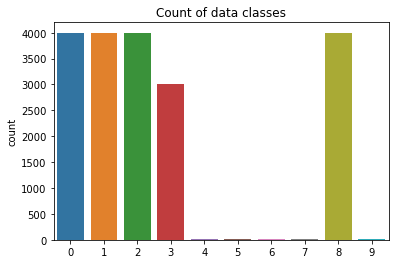

In [5]:
x_train, y_train = getData(dist, x_train, y_train)
getDist(y_train)

In [3]:
# Setup TenSEAL context.
context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=8192,
            coeff_mod_bit_sizes=[60, 40, 40, 60]
          )
          
context.generate_galois_keys()
context.global_scale = 2**40

In [4]:
# Check is context is private.
print("Is the context private?", ("Yes" if context.is_private() else "No"))

Is the context private? Yes


In [5]:
# Creating a copy of the context to share with the server. Ideally, the secret key should be drop.
public_context = context
#sk = context.secret_key()
#public_context.make_context_public()

# Context and ciphertext serialization
server_context = public_context.serialize(save_secret_key=True)

In [6]:
# Check is context is private.
print("Is the context private?", ("Yes" if context.is_private() else "No"))

Is the context private? Yes


In [7]:
key_query = {
    "context" : server_context
}

In [11]:
input_dictionary = (key_query)
file = open('key_query', 'wb')
pickle.dump(input_dictionary, file)
file.close()

In [10]:
# make a keys and output folders
directory1 = "keys"  
directory2 = "outputs"
# Parent Directory path 
parent_dir = "./"
    
# Path 
path1 = os.path.join(parent_dir, directory1) 
path2 = os.path.join(parent_dir, directory2) 

# make the directories
os.mkdir(path1)
print("Directory '% s' created" % directory1) 
os.mkdir(path2)
print("Directory '% s' created" % directory2) 

Directory 'keys' created
Directory 'outputs' created


In [6]:
# Initialize the CKKS Scheme 
context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree = 8192, coeff_mod_bit_sizes = [60, 40, 40, 60])
context.generate_galois_keys()
context.global_scale = 2 ** 40 #set the global scale for encryption 

In [7]:
# define a function to create the CKKS scheme and save 
def save_keys():
    # Serialize the secret key and save 
    secret_context = context.serialize(save_secret_key = True)
    utils.write_data("keys/secret_client1.txt", secret_context)

    # make the public key public and save 
    context.make_context_public()
    public_context = context.serialize()
    utils.write_data("keys/public_client1.txt", public_context)

In [8]:
# Save your keys
save_keys()

In [9]:
def flatten_weights():
    # Get the model weights
    weights = model.get_weights()
    
    # Flatten the weight matrix into a single vector
    flattened_weights = np.concatenate([w.flatten() for w in weights])
    return flattened_weights
flattened_weights = flatten_weights()

In [16]:
number_of_weights = len(flattened_weights)
inverse_number = [1/ number_of_weights]
print(number_of_weights)
print(inverse_number)

136074
[7.348942487176095e-06]


In [18]:
number_of_weights = len(flattened_weights)
inverse_number = [1/ number_of_weights]
encrypted_number_of_weights = ts.ckks_vector(context, inverse_number)
utils.write_data("outputs/number_of_weights.txt", encrypted_number_of_weights.serialize())

In [11]:
def encrypt_weights(): 
    # Encrypt and append each weight matrix
    encrypted_weights = ts.ckks_vector(context, flattened_weights)
    # Serialize and save the weights 
    utils.write_data("outputs/encrypted_weights.txt", encrypted_weights.serialize())
        
    #return encrypted_weights
# Encrypt the model weights 
encrypted_weights = encrypt_weights()

The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.


In [19]:
m2_proto = utils.read_data("outputs/new_encrypted_weight.txt")
m2 = ts.lazy_ckks_vector_from(m2_proto)
m2.link_context(context)

In [23]:
round(m2.decrypt(utils.read_data("keys/secret_client1.txt"))[0], 2) 

TypeError: incorrect type: <class 'bytes'> != SecretKey

In [ ]:
class EncryptedClient():
    def __init__ (self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        
    def flatten_weights(self):
    # Get the model weights
    weights = model.get_weights()
    
    # Flatten the weight matrix into a single vector
    flattened_weights = np.concatenate([w.flatten() for w in weights])
    return flattened_weights
    
    def encrypt_weights(self, flattened_weights): 
    # Encrypt and append each weight matrix
    encrypted_weights = ts.ckks_vector(context, flattened_weights)
    # Serialize and save the weights 
    utils.write_data("outputs/encrypted_weights.txt", encrypted_weights.serialize())   
    return encrypted_weights

    def decrypt_weights(self, encrypted_weights):
        # decrypt the encrypted weights 
        decrypted_weights = encrypted




In [ ]:
# Define Flower client
class FlowerClient(fl.client.NumPyClient):
    def get_parameters(self, config):
        return model.get_weights()

    def set_parameters(self, parameters, config):
        self.model.set_weights(parameters)
    
    def fit(self, parameters, config):
        model.set_weights(parameters)
        r = model.fit(x_train, y_train, epochs=1, validation_data=(x_test, y_test), verbose=0)
        hist = r.history
        print("Fit history : " ,hist)
        return model.get_weights(), len(x_train), {}

    def evaluate(self, parameters, config):
        model.set_weights(parameters)
        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        print("Eval accuracy : ", accuracy)
        return loss, len(x_test), {"accuracy": accuracy}

In [ ]:
'''# Start Flower client
fl.client.start_numpy_client(
        server_address="localhost:8080",
        client=FlowerClient(), 
        grpc_max_message_length = 1024*1024*1024
)'''